# Imports

In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# how to make this stylistically better? compile this all into one functions file?
from emission_line_fitting import gauss, kin_extract
from uncorrected_maps import flux, uncorrected_kin_maps, plot_maps
from model_cube import TT_point_spread, skyline_spec, inst_disp, modeled_gauss, model_data_cube, correct_dispersion
from int_disp import integrated_dispersion

# Uncorrected Kinematic Extraction

### Initial Target Parameters Guess

In [2]:
DATA_DIR = '/Users/jesshirt/research/osiris_survey/osiris_data/reduced_files/'

TARGET = 'a370_03312_AGN'
CUBE = DATA_DIR+TARGET+'_cube.fits'
TIP_TILT = DATA_DIR+TARGET+'_TT.fits'
INST = DATA_DIR+TARGET+'_inst.fits'

sky_ra_min = 14
sky_ra_max = 22
sky_dec_min = 33
sky_dec_max = 49

signal_ra_min = 22
signal_ra_max = 30
signal_dec_min = 40
signal_dec_max = 53

deltara = signal_ra_max - signal_ra_min
deltadec = signal_dec_max - signal_dec_min


TT_ra_min = 21
TT_ra_max = 33
TT_dec_min = 43
TT_dec_max = 53

guess = (1704, 0.7, 0.75, 0.0, 0.006)
bounds = [1706, 1, 1.0, 0.1, 0.1]

channel_low = 319
channel_high = 325


DATA_TAB

### Reading in guesses from table (for making changes/edits)

In [2]:
DATA_DIR = '/Users/cdf/Data/OSIRIS/20161021/from_jessie/'

TARGET = 'm0744_01203'
CUBE = DATA_DIR+TARGET+'_cube.fits'
TIP_TILT = DATA_DIR+TARGET+'_TT.fits'
INST = DATA_DIR+TARGET+'_inst.fits'

DATA_TAB = Table.read('kinematic_map_vals.txt', format='ascii')

for index, target in enumerate(DATA_TAB['target']):
    if target == TARGET:
        ind = index

sky_ra_min = DATA_TAB['sky_ra_min'][ind]
sky_ra_max = DATA_TAB['sky_ra_max'][ind]
sky_dec_min = DATA_TAB['sky_dec_min'][ind]
sky_dec_max = DATA_TAB['sky_dec_max'][ind]

signal_ra_min = DATA_TAB['signal_ra_min'][ind]
signal_ra_max = DATA_TAB['signal_ra_max'][ind] 
signal_dec_min = DATA_TAB['signal_dec_min'][ind]
signal_dec_max = DATA_TAB['signal_dec_max'][ind] 

deltara = signal_ra_max - signal_ra_min
deltadec = signal_dec_max - signal_dec_min


TT_ra_min = DATA_TAB['TT_ra_min'][ind]
TT_ra_max = DATA_TAB['TT_ra_max'][ind]
TT_dec_min = DATA_TAB['TT_dec_min'][ind]
TT_dec_max = DATA_TAB['TT_dec_max'][ind]

guess = (DATA_TAB['guess_wave'][ind], DATA_TAB['guess_amp'][ind], DATA_TAB['guess_sigma'][ind],
         DATA_TAB['guess_slope'][ind], DATA_TAB['guess_offset'][ind])
bounds = [DATA_TAB['bound_wave'][ind], DATA_TAB['bound_amp'][ind], DATA_TAB['bound_sigma'][ind],
         DATA_TAB['bound_slope'][ind], DATA_TAB['bound_offset'][ind]]

inst_dispersion = DATA_TAB['instrument_disp'][ind]

channel_low = DATA_TAB['channel_low'][ind]
channel_high = DATA_TAB['channel_high'][ind]

In [3]:
DATA_TAB

target,sky_ra_min,sky_ra_max,sky_dec_min,sky_dec_max,signal_ra_min,signal_ra_max,signal_dec_min,signal_dec_max,TT_ra_min,TT_ra_max,TT_dec_min,TT_dec_max,guess_wave,guess_amp,guess_sigma,guess_slope,guess_offset,bound_wave,bound_amp,bound_sigma,bound_slope,bound_offset,filter_sigma,instrument_disp,PSF_pixels,scale,stellar mass,channel_low,channel_high
str11,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
a370_02056,18,23,50,59,9,17,48,58,19,30,45,53,1487.0,0.7,0.75,0.0,0.006,1490.0,1.0,1.0,0.1,0.1,1.4,38.90323818237849,4.5522,0.05,8.77124639905,105,113
a370_03097,18,23,50,59,21,35,37,49,23,34,43,52,1670.0,0.7,0.75,0.0,0.006,1671.0,1.0,1.0,0.1,0.1,1.4,38.73738262666875,4.5729,0.1,9.32827216398,88,97
m0717_02064,17,22,50,59,21,28,31,42,14,27,45,53,2013.0,0.7,0.75,0.0,0.006,2014.0,1.0,1.0,0.1,0.1,1.2,47.41891964870514,3.5735,0.1,8.17842499413,230,242
m0744_00920,20,26,50,59,25,40,8,72,14,29,27,39,1490.0,0.7,0.75,0.0,0.006,1493.0,15.0,1.0,0.1,0.1,0.5,50.69087210148318,2.62237,0.1,9.05378949183,120,131
m0744_01203,24,29,50,59,30,43,30,41,28,39,45,56,1740.0,0.7,0.75,0.0,0.006,1740.0,1.5,1.0,0.1,0.1,1.0,30.25190053777353,3.91257,0.05,9.26031291738,89,99
m1149_00593,24,30,20,40,28,40,49,60,17,27,24,35,1629.0,0.7,0.75,0.0,0.006,1630.0,1.5,1.0,0.1,0.1,1.4,37.06318372667738,5.31462,0.1,9.34,168,180
m1149_00683,27,32,38,52,38,46,40,52,32,39,27,37,1758.0,0.7,0.75,0.0,0.006,1759.0,1.5,1.0,0.1,0.1,1.5,34.683335224208285,4.40746,0.1,7.9,180,194
m1149_01058,24,29,50,59,23,33,50,65,15,27,28,39,1475.0,0.7,0.75,0.0,0.006,1478.0,1.5,1.0,0.1,0.1,1.1,37.953710176734035,3.941188,0.05,8.81,46,54
m1149_01802,28,34,50,59,13,26,55,65,22,27,29,36,2075.0,0.7,0.75,0.0,0.006,2080.0,1.0,1.0,0.1,0.008,1.1,38.92307231343197,3.68314,0.05,9.70618463402,153,164


### Fit Gaussian to Ha Emission Line

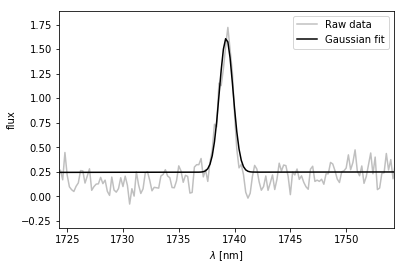

In [13]:
kin_extract(CUBE, sky_ra_min, sky_ra_max, sky_dec_min, sky_dec_max,
                signal_ra_min, signal_ra_max, signal_dec_min, signal_dec_max,
                guess, bounds)

### Uncorrected Kinematic Maps

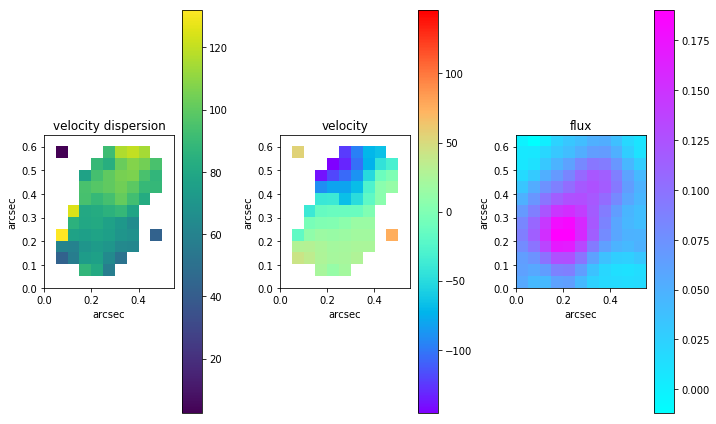

In [14]:
# make sure to only keep uncertainties, etc., of good pixels!!
# still need to code this part

filt = DATA_TAB['filter_sigma'][ind]
#filt = 1.4

dispersion, velocity, scale, params, wave_list, combined_mask, z, tot_flux = uncorrected_kin_maps(CUBE, sky_ra_min, sky_ra_max, sky_dec_min, sky_dec_max,
                     signal_ra_min, signal_ra_max, signal_dec_min, signal_dec_max, guess, bounds, filt,
                     channel_low, channel_high, edges=True)

uncorr_local_disp = np.mean(dispersion)
uncorr_local_disp_err = np.std(dispersion)/np.sqrt(len(dispersion.compressed()))



# plot velocity + dispersion maps

plot_maps(dispersion, velocity, deltara, deltadec, scale, tot_flux)



### Remove misc bad pixels

In [ ]:
dispersion.mask[2][-2] = True
#dispersion.mask[4][-2] = True
#dispersion.mask[8][-2] = True

#dispersion.mask[4][4] = True

uncorr_local_disp = np.mean(dispersion)
uncorr_local_disp_err = np.std(dispersion)/np.sqrt(len(dispersion.compressed()))



plot_maps(dispersion, velocity, data, deltara, deltadec, scale)



# Integrated Dispersion

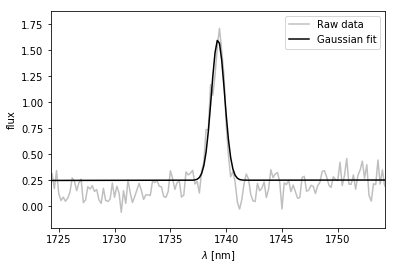

In [15]:
corr_integrated_disp, corr_integrated_disp_err = integrated_dispersion(CUBE,
                      sky_ra_min, sky_ra_max, sky_dec_min, sky_dec_max,
                      signal_ra_min, signal_ra_max, signal_dec_min, signal_dec_max,
                      guess, bounds, inst_dispersion, filt, plot=True)

# Correcting Kinematic Maps

## Modeling 3D Data Cube

### Model PSF of Tip/Tilt Star

In [16]:
# what to do when fwhm in x and y are very uneven (ex. m1149_01802)?

TT_psf = TT_point_spread(TIP_TILT, TT_ra_min, TT_ra_max, TT_dec_min, TT_dec_max, 0)

TT_psf # (x, y, avg)



(1.89178094189832, 1.7974893515053147, 1.8446351467018174)

### Instrument Dispersion

#### Plot Skylines

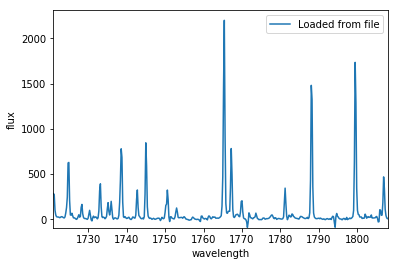

In [17]:
wave, data = skyline_spec(INST)

#plot data imported from fits file
plt.plot(wave, data,label = 'Loaded from file')
    
# give bounds for plotting
xmin = min(wave)
xmax = max(wave)
ymin = 1.05 * min(data)
ymax = 1.05 * max(data)
plt.axis([xmin, xmax, ymin, ymax])

# add labels and title to plot
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

#### Fit Skyline and Calculated Dispersion

In [ ]:
#inst_dispersion = inst_disp(INST, wave, data, 1518, 1519, 12500, 14500)
inst_dispersion = inst_disp(INST, wave, data, 2033, 2034, 12000, 13500)

### Model Data Cube and Make Corrected Dispersion Map

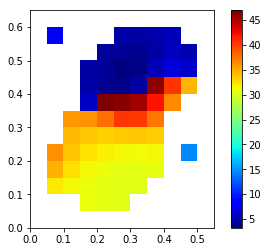

In [18]:
model = model_data_cube(params, combined_mask, TT_psf[2], inst_dispersion, wave_list, filt, deltara, deltadec)

disp = correct_dispersion(dispersion, deltara, deltadec, wave_list, model, guess, bounds,
                          combined_mask, scale, plot=True)

# Corrected Kinematic Maps

### Corrected Velocity and Velocity Dispersion Maps

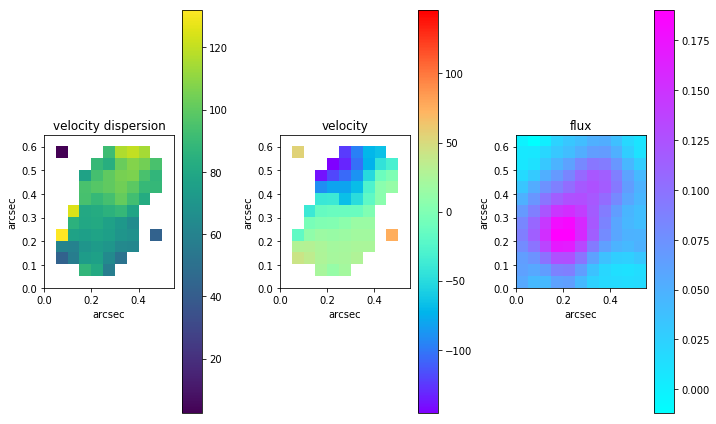

In [19]:
corr_local_disp = np.mean(disp)
corr_local_disp_err = np.std(disp)/np.sqrt(len(disp.compressed()))



#plot_maps(disp, velocity, deltara, deltadec, scale)

velocityscale = max(np.max(velocity), abs(np.min(velocity)))
cmap_disp = matplotlib.cm.viridis
cmap_disp.set_bad(color='white')

cmap_vel = matplotlib.cm.rainbow
cmap_vel.set_bad(color='white')

cmap_flux = matplotlib.cm.cool

plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.imshow(dispersion, cmap = cmap_disp, origin = 'lower'
            ,extent = (0, deltadec * scale, 0, deltara * scale)
            )
plt.colorbar()
plt.title('velocity dispersion')
plt.xlabel('arcsec') #dec
plt.ylabel('arcsec') #RA

plt.subplot(1,3,2)    
plt.imshow(velocity, cmap = cmap_vel, origin = 'lower', vmin = -velocityscale, vmax = velocityscale
            ,extent = (0, deltadec * scale, 0, deltara * scale)
            )
plt.colorbar()
plt.title('velocity')
plt.xlabel('arcsec') #dec
plt.ylabel('arcsec') #RA

plt.subplot(1,3,3)
plt.imshow(tot_flux, cmap = cmap_flux, origin = 'lower'
            ,extent = (0, deltadec * scale, 0, deltara * scale)
            )
plt.colorbar()
plt.title('flux')
plt.xlabel('arcsec') #dec
plt.ylabel('arcsec') #RA

plt.tight_layout()
#plt.savefig('/Users/jesshirt/research/osiris_survey/osiris_data/reduced_files/koki/kinematic_maps_50mas.pdf')
plt.show()

### Save Velocity and Velocity Dispersion Maps

In [ ]:
#DISP_DIR = '/Users/jesshirt/research/osiris_survey/target_files/dispersion/'
#VEL_DIR = '/Users/jesshirt/research/osiris_survey/target_files/velocity/'

DIR = '/Users/jesshirt/research/osiris_survey/osiris_data/reduced_files/koki/'

vdisp_file = '{}_dispersion.fits'.format(DIR+TARGET)
velocity_file = '{}_velocity.fits'.format(DIR+TARGET)

#vdisp_file = '{}_dispersion.fits'.format(DISP_DIR+TARGET)
#velocity_file = '{}_velocity.fits'.format(VEL_DIR+TARGET)


g = fits.writeto(vdisp_file, np.asarray(disp), overwrite = True)
h = fits.writeto(velocity_file, np.asarray(velocity), overwrite = True)

### Save Target Parameters to Table

In [ ]:
#DIR = '/Users/jesshirt/research/osiris_survey/target_files/'
#t = Table(names=('target',
#                 'sky_ra_min', 'sky_ra_max', 'sky_dec_min', 'sky_dec_max',
#                 'signal_ra_min', 'signal_ra_max', 'signal_dec_min', 'signal_dec_max',
#                 'TT_ra_min', 'TT_ra_max', 'TT_dec_min', 'TT_dec_max',
#                 'guess_wave', 'guess_amp', 'guess_sigma', 'guess_slope', 'guess_offset',
#                 'bound_wave', 'bound_amp', 'bound_sigma', 'bound_slope', 'bound_offset',
#                 'filter_sigma', 'instrument_disp', 'PSF_pixels'),
#          dtype=('S11', 
#                int, int, int, int, 
#                int, int, int, int,
#                int, int, int, int,
#                float, float, float, float, float, 
#                float, float, float, float, float, 
#                float, float, float))
#
#t.add_row([TARGET, 
#           sky_ra_min, sky_ra_max, sky_dec_min, sky_dec_max,
#           signal_ra_min, signal_ra_max, signal_dec_min, signal_dec_max,
#           TT_ra_min, TT_ra_max, TT_dec_min, TT_dec_max,
#           guess[0], guess[1], guess[2], guess[3], guess[4],
#           bounds[0], bounds[1], bounds[2], bounds[3], bounds[4],
#           filt, inst_dispersion, TT_psf[2]])
#
#t.write(DIR+'kinematic_map_vals.txt', format='ascii', overwrite=True)

In [ ]:
DIR = '/Users/jesshirt/research/osiris_survey/target_files/'
t = Table.read(DIR+'kinematic_map_vals.txt', format='ascii')

In [ ]:
DIR = '/Users/jesshirt/research/osiris_survey/target_files/'
t = Table.read(DIR+'kinematic_map_vals.txt', format='ascii')

if t[ind]['target'] == TARGET:
    t[ind] = [TARGET, 
           sky_ra_min, sky_ra_max, sky_dec_min, sky_dec_max,
           signal_ra_min, signal_ra_max, signal_dec_min, signal_dec_max,
           TT_ra_min, TT_ra_max, TT_dec_min, TT_dec_max,
           guess[0], guess[1], guess[2], guess[3], guess[4],
           bounds[0], bounds[1], bounds[2], bounds[3], bounds[4],
           filt, inst_dispersion, TT_psf[2], scale]

if TARGET not in t['target']:
    t.add_row([TARGET, 
           sky_ra_min, sky_ra_max, sky_dec_min, sky_dec_max,
           signal_ra_min, signal_ra_max, signal_dec_min, signal_dec_max,
           TT_ra_min, TT_ra_max, TT_dec_min, TT_dec_max,
           guess[0], guess[1], guess[2], guess[3], guess[4],
           bounds[0], bounds[1], bounds[2], bounds[3], bounds[4],
           filt, inst_dispersion, TT_psf[2], scale])

t.sort('target')
t


In [ ]:
t.write(DIR+'kinematic_map_vals.txt', format='ascii', overwrite=True)

In [ ]:
#DIR = '/Users/jesshirt/research/osiris_survey/target_files/'
#kinval = Table(names=('target', 'redshift',
#                 'uncorrected local dispersion', 'uncorrected local dispersion unc',
#                'corrected local disperison', 'corrected local dispersion unc',
#                 'integrated dispersion', 'integrated dispersion unc',
#                'instrument dispersion'),
#          dtype=('S13', float, 
#                float, float, 
#                float, float,
#                float, float,
#                float))

In [ ]:
kinval = Table.read('/Users/jesshirt/research/osiris_survey/target_files/kin_vals.txt', format='ascii')

kinval.add_row([TARGET, z,
           uncorr_local_disp, uncorr_local_disp_err,
           corr_local_disp, corr_local_disp_err,
           corr_integrated_disp, corr_integrated_disp_err,
           inst_dispersion])

kinval.sort('target')
kinval.write(DIR+'kin_vals.txt', format='ascii', overwrite=True)